# An atropy example

This example will provide all necessary information to use the functionalities provided by `atropy`. It helps the user understand how to translate chemical reactions into our implementation and explains some ideas behind our code. We show how to run stochastic simulations of a chemical reaction network by using the Python interface of the `atropy` code. We will show how to setup a model, specify the low-rank algorithm used and run the simulations for the lambda phage example.

## The lambda phage model

First we need to take a look at the lambda phage model and its chemical reactions. The lambda phage is a bacteriophage that infects the bacterial species E. coli. and stays dormant in the host or breaks out of the host, after multiplying and reassembling itself. The model consists out of 5 species and 10 reactions with a corresponding propensity function, visualized in this table:

$$
\begin{array}{|c|c|c|}
\hline
\mu & \text{Reaction } R_\mu & \text{Propensity function } \alpha_\mu(\mathbf{x}) \\
\hline
0 & \star \rightarrow S_0 & a_0 b_0/(b_0 + x_1) \\
1 & \star \rightarrow S_1 & (a_1 + x_4) b_1/(b_1 + x_0) \\
2 & \star \rightarrow S_2 & a_2 b_2 x_1/(b_2 x_1 + 1) \\
3 & \star \rightarrow S_3 & a_3 b_3 x_2/(b_3 x_2 + 1) \\
4 & \star \rightarrow S_4 & a_4 b_4 x_2/(b_4 x_2 + 1) \\
5 & S_0 \rightarrow \star & c_0 \cdot x_0 \\
6 & S_1 \rightarrow \star & c_1 \cdot x_1 \\
7 & S_2 \rightarrow \star & c_2 \cdot x_2 \\
8 & S_3 \rightarrow \star & c_3 \cdot x_3 \\
9 & S_4 \rightarrow \star & c_4 \cdot x_4 \\
\hline
\end{array}
$$

The coeffiecients used for the propensity function are given by

$$
\renewcommand{\arraystretch}{1.5} % Increase line spacing
\begin{array}{|c|c|c|c|}
\hline
i & a_i & b_i & c_i \\
\hline
0 & 0.5 & 0.12 & 0.0025 \\
1 & 1 & 0.6 & 0.0007 \\
2 & 0.15 & 1 & 0.0231 \\
3 & 0.3 & 1 & 0.01 \\
4 & 0.3 & 1 & 0.01 \\
\hline
\end{array}
$$

## Translating the model to the implementation

We are interested in how to translate the model to the `atropy` implementation. Before we can begin, we need to import some necessary libraries. Both numpy and sympy are used when generating the inital condition. For plotting we need matplotlib and atropy_core, the core library of `atropy`. It gets installed automatically when installing `atropy` and is thus instantly available. Lastly, from atropy.src.generator, we import the necessary classes and functions to set up our model and partition and also run the code.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

from atropy_core.output_helper import TimeSeries

from atropy.src.generator import Model, Partitioning, run, species

Before we can set up our reaction system, we need to define the species. For this the function `species` from the `atropy` library is used. In our reaction network for the lambda phage example there are 5 species. Thus we define

In [ ]:
S0, S1, S2, S3, S4 = species("S0, S1, S2, S3, S4")

Next we need to initialize the model class. To do so, we pass our defined species to the class `Model` in `atropy`.

In [ ]:
model = Model((S0, S1, S2, S3, S4))

To add our reactions, we do not only need the reaction itself, but also the corresponding propensity function. Thus we need to define the coefficients used for the propensity functions from our lambda phage reaction network.

In [ ]:
a0 = 0.5
a1 = 1.0
a2 = 0.15
a3 = 0.3
a4 = 0.3

b0 = 0.12
b1 = 0.6
b2 = 1.0
b3 = 1.0
b4 = 1.0

c0 = 0.0025
c1 = 0.0007
c2 = 0.0231
c3 = 0.01
c4 = 0.01

Now let us consider how to translate our chemical reactions to the implementation. For better understanding we will first consider only two reactions, namely reaction $R_1$ and $R_5$. For reaction $R_1$, our species $S_1$ gets generated from unknown elements. The propensity function is given by $(a_1 + x_4) b_1 / (b_1 + x_0)$. In our code we exchange $x_i$ for $S_i$. In this way we do not need to define any more variables. Also note that the propensity function needs to be factorizable. The reaction can be added using the preimpemented function `add_reaction`, which is part of the `Model` class. The first parameter for the function are the reactants, the second the products and the third the propensity function. The propensity function can be passed to `add_reaction` in factorized form using a dictionary or in a non factorized form. If added in non factorized form, `atropy` will try to factorize it and send an error, if not possible. We can add reaction $R_1$ to our model:

In [ ]:
model.add_reaction(0, S1, {S0: b1 / (b1 + S0), S4: a1 + S4})

Let us add reaction $R_5$. Here species $S_0$ decays into unknown elements. Our propensity function is given by the law of mass action. Therefore we can use an abreviated form and only pass the coefficient instead of the full dictionary for the propensity function:

In [ ]:
model.add_reaction(S0, 0, c0)

There is also the functionality of adding multiple reactions with just one function call. This is possible using the function `add_reactions` and passing a list of reactants, products and propensity functions. We could add reaction $R_1$ and $R_5$ by 

In [ ]:
model.add_reactions([0, S0], [S1, 0], [{S0: b1 / (b1 + S0), S4: a1 + S4}, c0])

Note that using this method can be confusing and is not recommended. Adding the full reaction network for the lambda phage example in a clearly structured way can be done like this:

In [ ]:
model.add_reaction(0, S0, {S1: a0 * b0 / (b0 + S1)})
model.add_reaction(0, S1, {S0: b1 / (b1 + S0), S4: a1 + S4})
model.add_reaction(0, S2, {S1: a2 * b2 * S1 / (b2 * S1 + 1.0)})
model.add_reaction(0, S3, {S2: a3 * b3 * S2 / (b3 * S2 + 1.0)})
model.add_reaction(0, S4, {S2: a4 * b4 * S2 / (b4 * S2 + 1.0)})
model.add_reaction(S0, 0, c0)
model.add_reaction(S1, 0, c1)
model.add_reaction(S2, 0, c2)
model.add_reaction(S3, 0, c3)
model.add_reaction(S4, 0, c4)

When we finally added all of our reactions to the model, all left to do is generating the reaction system, using the corresponding function:

In [ ]:
model.generate_reaction_system()

## Setup the low-rank solver

To setup our low rank solver, we need to take a closer look at our species and the reaction propensities. We want to use a good partition which reduces the computational complexity of our problem, but still gives accurate results. The idea is to form cuts between dependencies of species in our dependecy graph and generate tree structures hierarchically. To understand this better, we will look at the dependency graph of our lambda phage example with some already proposed cuts:

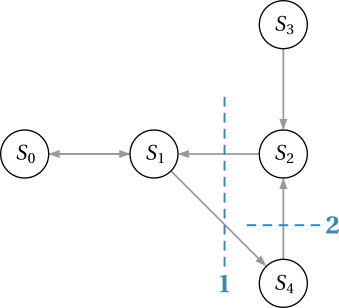

In [ ]:
from IPython.display import SVG, display

display(SVG(filename='/home/stefan/atropy_pybind/lambda_phage_g0_n.svg'))

The notation $A \rightarrow B$ indicates the dependency of species $A$ on species $B$ due to some specific reaction propensity. The cuts are chosen in such a way that tightly coupled species are together in the same partition. This selection of cuts results in the following tree structure, where the small numbers at the leaves denote on which species the low-rank factors depend:

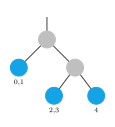

In [12]:
from IPython.display import SVG, display

display(SVG(filename='/home/stefan/atropy_pybind/lambda_phage_p0.svg'))

In our implementation we denote such a structure using a string. Each partition is inside a set of brackets. We give our partition from above the name p0.

In [ ]:
p0 = "(S0 S1)((S2 S3)(S4))"

Additionally, we need to set the rank for our calculations. For each partition the algorithm uses rank $r$ basis functions. The smaller the rank, the faster the calculations are, but we also loose accuracy. For the hierarchical tree structure we can define the rank for each level, but partitions on the same level use the same rank. This means that we need to assign a rank for each cut of the reaction system and the resulting partitions are approximated to the same degree. In our example we thus need to define two ranks, which we do in a numpy array in the implementation.

In [ ]:
r = np.array([5, 4])

Finally we can set up our `Partitioning` class of `atropy` by passing the partition, array of ranks and the model to our class:

In [ ]:
partitioning = Partitioning(p0, r, model)

We have set up our partition as shown in the first picture. Next we need to generate the tree as shown in the second picture. Before doing so, we need to add some grid parameters. Here n denotes the amount of gridpoints for each species and liml is the lower limit of the population number, which is equal to 0 in most examples. The parameter binsize almost always has to be set as in our example.

In [ ]:
n = np.array([16, 41, 11, 11, 11])
d = n.size
binsize = np.ones(d, dtype=int)
liml = np.zeros(d)
partitioning.add_grid_params(n, binsize, liml)

After we added our grid parameters, we can generate the tree.

In [ ]:
partitioning.generate_tree()

Next we initialize our initial condition class, before assigning values to it.

In [ ]:
n_basisfunctions = r
partitioning.generate_initial_condition(n_basisfunctions)

## Setup the initial condition

The inital condition can be arbitrary, but needs to be low rank. We will give an example of 2 initial conditions. First lets consider the already low rank inital condition

$$
P(0,x) = \prod_{i=0}^{d-1} f(x_i) \hspace{1cm} \text{with} \hspace{1cm} f(x_i) = e^{-x_i^2}.
$$

It is even of rank 1, because it can be split into a product of functions, each depending only on 1 species. For this type of inital condition we provide the function `set_initial_condition`. It helps the user to translate the information of the inital condition to the nodes of the generated tree. To use it, the function for each species first needs to be written into a dictionary:

In [ ]:
functions_dict = {
    S0: sp.exp(-S0**2),
    S1: sp.exp(-S1**2),
    S2: sp.exp(-S2**2),
    S3: sp.exp(-S3**2),
    S4: sp.exp(-S4**2),
}

Now we can call `set_initial_condition`:

In [ ]:
partitioning.set_initial_condition(functions_dict)

We still need to normalize our values. For that we calculate the norm and divide by it:

In [ ]:
_, marginal_distribution = partitioning.tree.calculateObservables(
    np.zeros(partitioning.tree.root.grid.d(), dtype="int")
)
norm = np.sum(marginal_distribution[partitioning.tree.species_names[0]])
print("norm:", norm)
partitioning.tree.root.Q[0, 0, 0] /= norm

To check if the tree and inital condition generation was correct, we can provoke an output in the console. This gives us information about the nodes of our tree.

In [ ]:
print(partitioning.tree)

Also more complex inital conditions can be used, but only with caution. We could choose the multinomial distribution with parameters $n=3$ and $p=(0.05,\dots ,0.05)$, meaning

$$
P(0, \mathbf{x}) = 
\begin{cases}
\frac{3!}{x_0! \cdots x_4!(3 - |\mathbf{x}|)!} 0.05^{|\mathbf{x}|} (1 - 5 \cdot 0.05)^{3 - |\mathbf{x}|} & \text{if } |\mathbf{x}| \leq 3, \\
0 & \text{else,}
\end{cases}
$$

with $|\mathbf{x}| = x_0+\cdots +x_4$. This distribution is not low rank. Thus before applying it to the nodes, we need to perform singular value decomposition to generate a low rank intial condition. For simplicity, we will move on with the first inital condition.

## Running the code

Using the `run` function from `atropy`, we can finally run our simulation. There are several parameters we need to pass. For the first parameter we need to pass the partitioning defined above. Next comes the desired output name for the generated files. After that there is the timestep size and final time of our simulation. The last three parameters are snapshot, substeps and method. They all have a standard parameter, thus only need to be passed if another value is desired. The snapshot parameter contains the number of generated output files during our simulation, where the standard value is 2. The substep parameter is an advanced parameter and for most cases the standard value of 1 can be chosen. For the method there are 4 different options: implicit_Euler, explicit_Euler, Crank_Nicolson and the standard option RK4. In our lambda phage example we run the simulation until final time 10 with a timestep size of $10^{-3}$ and implicit Euler as the time integration method.

In [ ]:
run(partitioning, "output_lambda_phage", 1e-3, 10,snapshot=10,
    method="implicit_Euler")

## Plotting the results

After the simulation was executed we can plot our obtained results. To load the generated NetCDF files the `TimeSeries` class from `atropy_core` can be used. In the following we plot the first moments for each of our species.

In [ ]:
time_series = TimeSeries("output_lambda_phage")
concentrations = time_series.calculateMoments()
t = time_series.time

fig, ax = plt.subplots(figsize=(7, 4))

observables = ["S0", "S1", "S2", "S3", "S4"]
observables_alt = ["$S_0$", "$S_1$", "$S_2$", "$S_3$", "$S_4$"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, (o, o_alt) in enumerate(zip(observables, observables_alt, strict=False)):
    ax.plot(t, concentrations[0][o], "-", label=o_alt, color=colors[i], alpha=0.7)
ax.set_ylabel("$\\langle x_i(t) \\rangle$")
ax.set_ylim([0.0, 12.0])

plt.setp(ax, xlabel="$t$", xlim=[0.0, 10.0],
         xticks=[0.0, 2.5, 5.0, 7.5, 10.0])

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = (sum(ll, []) for ll in zip(*lines_labels, strict=False))
fig.legend(lines, labels, ncols=5, loc="upper center")

plt.savefig("plots/lambda_phage_concentrations.pdf")